In [1]:
import africanus
import casacore.tables.table as table

import numpy as np
import astropy.units as u
from astropy import constants as const

import matplotlib.pyplot as plt

from scipy.special import jv

from dask.diagnostics import ProgressBar
import dask
import dask.array as da
from daskms import xds_from_ms, xds_from_table, xds_to_table
from africanus.coordinates.dask import radec_to_lm
from africanus.rime.dask import wsclean_predict

# Simulate a Knoll 4 beam

6.9 deg from pointing is roughly where the first null of the voltage beam lives at 1.35 GHz.

 # Just for visualization

In [70]:
DIAM = 5 * u.m
f = 1.35 * u.GHz
lm = np.mgrid[-40:40:2000j,-40:40:2000j] * u.deg

In [71]:
r = (np.sqrt(lm[0]**2 + lm[1]**2) * DIAM * f/(2*const.c)).to(u.rad)

In [72]:
beam = ((1 * u.mm) * f/const.c) * -1j * jv(3, r.value)/r.value

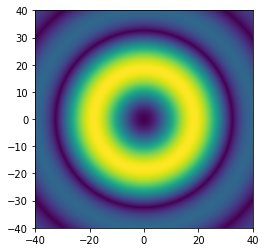

In [74]:
plt.imshow(np.abs(beam), extent=[-40, 40, -40, 40])

In [69]:
np.abs(beam).max().to(u.dimensionless_unscaled)

<Quantity 0.00049881>

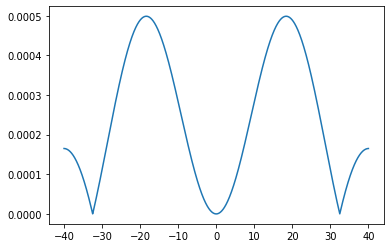

In [80]:
plt.plot(lm[1][beam.shape[0]//2].to(u.deg), np.abs(beam[:, beam.shape[0]//2]).to(u.dimensionless_unscaled))

## Some codex work. Get a source. FT it and add corruption.

In [81]:
with table('/fastpool/data/W-15int-8000chan/00.ms') as t:
    uvw = t.getcol('UVW', 0, 1000)

Successful readonly open of default-locked table /fastpool/data/W-15int-8000chan/00.ms: 22 columns, 2096128 rows


In [84]:
10/np.sqrt(2)/57

0.1240538212607978

In [82]:
from africanus.rime import wsclean_predict

In [98]:
lm = np.array([[0.124, 0.124]])
source_type=np.array(["POINT"])
flux = np.array([1.0])
coeffs = np.array([[0]])
log_poly = True
ref_freq = np.array([1.35e9])
frequency = np.array([0.7e0, 1.35e9, 2e9])
coh = wsclean_predict(uvw, lm, source_type, flux, coeffs, log_poly, ref_freq, np.array([[0,0,0]]), frequency)

In [101]:
coh.shape

(1000, 3, 1)

In [103]:
from numpy.linalg import norm

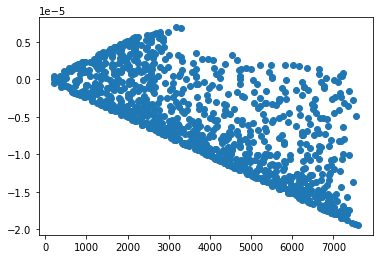

In [106]:
plt.scatter(norm(uvw, axis=1), np.angle(coh[:,0,0]))

## A quick test
Generate a point source at 3 deg away from the pointing center, and then image. Ignore the W terms for now.

In [114]:
def support_tables(ms):
    n = {k: '::'.join((ms, k)) for k
         in ("ANTENNA", "DATA_DESCRIPTION", "FIELD",
             "SPECTRAL_WINDOW", "POLARIZATION")}

    # All rows at once
    lazy_tables = {"ANTENNA": xds_from_table(n["ANTENNA"])}

    compute_tables = {
        # Fixed shape rows
        "DATA_DESCRIPTION": xds_from_table(n["DATA_DESCRIPTION"]),
        # Variably shaped, need a dataset per row
        "FIELD": xds_from_table(n["FIELD"],
                                group_cols="__row__"),
        "SPECTRAL_WINDOW": xds_from_table(n["SPECTRAL_WINDOW"],
                                          group_cols="__row__"),
        "POLARIZATION": xds_from_table(n["POLARIZATION"],
                                       group_cols="__row__"),
    }

    lazy_tables.update(dask.compute(compute_tables)[0])
    return lazy_tables

In [117]:
tables = support_tables('/fastpool/data/20210226M-1350MHz-1chan.ms')

In [121]:
ant_ds = tables["ANTENNA"]
field_ds = tables["FIELD"]
ddid_ds = tables["DATA_DESCRIPTION"]
spw_ds = tables["SPECTRAL_WINDOW"]
pol_ds = tables["POLARIZATION"]

In [124]:
from africanus.rime.dask import wsclean_predict

In [157]:
# List of write operations
writes = []


for xds in xds_from_ms('/fastpool/data/20210226M-1350MHz-1chan.ms',
                       columns=["UVW", "ANTENNA1", "ANTENNA2", "TIME"],
                       group_cols=["FIELD_ID", "DATA_DESC_ID"],
                       chunks={"row": 1e5}):
    vis = wsclean_predict(xds['UVW'], da.array([[0.124/5, 0.124/5]]), da.array(['POINT']), da.array([1.0]),
                    da.array([[0]]), da.array([True]), da.array([1.35e9]), da.array([[0,0,0]]), da.array([1.35e9]))
    vis = vis * da.array([1, 0, 0, 1]) # this is not 0.5 because there's a factor of 2 in the RIME
    print(vis.shape)
    # Assign visibilities to MODEL_DATA array on the dataset
    xds = xds.assign(MODEL_DATA=(("row", "chan", "corr"), vis))
    # Create a write to the table
    write = xds_to_table(xds, '/fastpool/data/20210226M-1350MHz-1chan.ms', ['MODEL_DATA'])
    # Add to the list of writes
    writes.append(write)

(2096128, 1, 4)


In [158]:
with ProgressBar():
    dask.compute(writes)

[########################################] | 100% Completed |  1.7s


Don't forget the factor of 2 in the RIME!

In [165]:
from africanus.coordinates import radec_to_lm

In [173]:
radec_to_lm(np.array([[1.8169576/57, 38.5374096/57]]), phase_centre=np.array([0., 37.129833/57]))

array([[0.02486013, 0.02493207]])

In [172]:
0.124/5

0.0248

Ok so the lms make sense and I should just use those. The units are radians.

## Now let's evaluate the beam!
I think the beam is defined in spherical coordinates, so we use angular offsets to evaluate it. But the visibility calculation is in l,m,n, so we'd do that.

In [9]:
from scipy.special import jv
DIAM = 5
c1=1.091
c4=0.957
c6=-0.139
c11=0.445
LAMBD = 3e8/1.35e9

In [10]:
def vBz(theta, phi, m, n, lambd):
    r = theta * DIAM / (2 * lambd)
    if m>= 0:
        return jv(n+1, 2 * np.pi * r) * np.cos(m*phi) / (np.pi * r)
    else:
        return jv(n+1, 2 * np.pi * r) * np.sin(-m*phi) / (np.pi * r)

In [11]:
thetaphi = np.mgrid[0:np.pi/3:1000j,0:2*np.pi:1000j]

In [12]:
uniform = vBz(thetaphi[0], thetaphi[1], 0, 0, LAMBD)

/tmp/ipykernel_1653635/277284853.py:4: RuntimeWarning: invalid value encountered in true_divide
  return jv(n+1, 2 * np.pi * r) * np.cos(m*phi) / (np.pi * r)


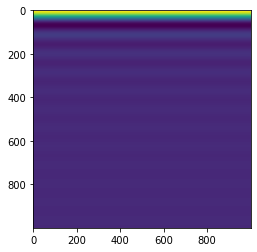

In [6]:
plt.imshow(uniform)

In [7]:
x = np.sin(thetaphi[0]) * np.sin(thetaphi[1])
y = np.sin(thetaphi[0]) * np.cos(thetaphi[1])

In [16]:
x.max()

0.8660243332286005

In [17]:
y.max()

0.8660254037844386

/tmp/ipykernel_273190/461256925.py:2: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  ax.pcolor(x, y, uniform, shading='auto')


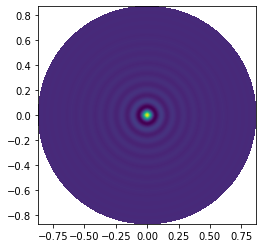

In [8]:
fig, ax = plt.subplots()
ax.pcolor(x, y, uniform, shading='auto')
ax.set_aspect(1)

(0.0, 5.0)

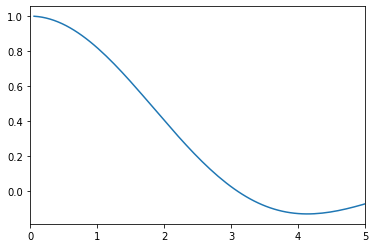

In [9]:
plt.plot(thetaphi[0][:,0] * 57, uniform[:,0])
plt.xlim([0, 5])

In [13]:
full_beam = (c1 * vBz(thetaphi[0], thetaphi[1], 0, 0, LAMBD) +
             c4 * vBz(thetaphi[0], thetaphi[1], 0, 2, LAMBD) +
             c6 * vBz(thetaphi[0], thetaphi[1], 2, 2, LAMBD) +
             c11 * vBz(thetaphi[0], thetaphi[1], 2, 4, LAMBD))

/tmp/ipykernel_1653635/277284853.py:4: RuntimeWarning: invalid value encountered in true_divide
  return jv(n+1, 2 * np.pi * r) * np.cos(m*phi) / (np.pi * r)


/tmp/ipykernel_273190/1658791799.py:2: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  ax.pcolor(x, y, full_beam, shading='auto')


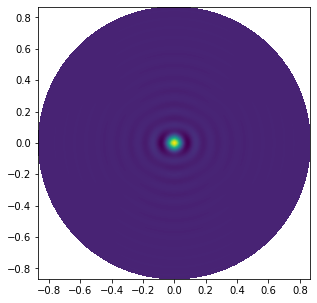

In [15]:
fig, ax = plt.subplots(figsize=(5,5))
ax.pcolor(x, y, full_beam, shading='auto')
ax.set_aspect(1)

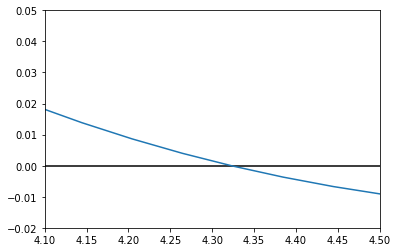

In [260]:
plt.plot(thetaphi[0][:,0] * 57.3, full_beam[:,0])
plt.ylim([-0.02, 0.05])
plt.xlim([4.1,4.5])
plt.hlines(0, 0, 10, color='k')

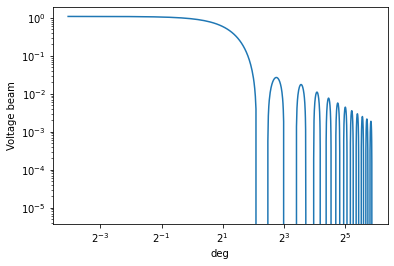

In [14]:
plt.plot(thetaphi[0][:,0] * 57.3, full_beam[:,0])
plt.xlabel('deg')
plt.ylabel('Voltage beam')
plt.yscale('log')
plt.xscale('log', base=2)

In [16]:
full_beam_0_7_GHz = (c1 * vBz(thetaphi[0], thetaphi[1], 0, 0, 3e8/0.7e9) +
             c4 * vBz(thetaphi[0], thetaphi[1], 0, 2, 3e8/0.7e9) +
             c6 * vBz(thetaphi[0], thetaphi[1], 2, 2, 3e8/0.7e9) +
             c11 * vBz(thetaphi[0], thetaphi[1], 2, 4, 3e8/0.7e9))
full_beam_2_GHz = (c1 * vBz(thetaphi[0], thetaphi[1], 0, 0, 3e8/2e9) +
             c4 * vBz(thetaphi[0], thetaphi[1], 0, 2, 3e8/2e9) +
             c6 * vBz(thetaphi[0], thetaphi[1], 2, 2, 3e8/2e9) +
             c11 * vBz(thetaphi[0], thetaphi[1], 2, 4, 3e8/2e9))

/tmp/ipykernel_1653635/277284853.py:4: RuntimeWarning: invalid value encountered in true_divide
  return jv(n+1, 2 * np.pi * r) * np.cos(m*phi) / (np.pi * r)


Text(0, 0.5, 'Voltage beam')

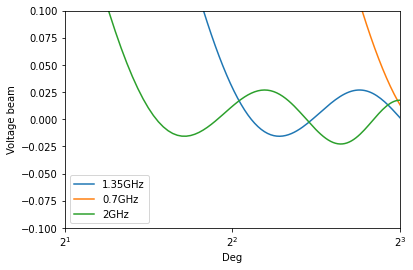

In [17]:
plt.plot(thetaphi[0][:,0] * 57.3, full_beam[:,0], label='1.35GHz')
plt.plot(thetaphi[0][:,0] * 57.3, full_beam_0_7_GHz[:,0], label='0.7GHz')
plt.plot(thetaphi[0][:,0] * 57.3, full_beam_2_GHz[:,0], label='2GHz')
plt.legend()
plt.xscale('log', base=2)
plt.xlim([2, 8])
plt.ylim([-0.1,0.1])
plt.xlabel('Deg')
plt.ylabel('Voltage beam')

Put a source near the null. Evaluate beam + distortions.

Let's put the source at 4.34 degrees away from pointint center, where we get a null at 1.35 GHz.

# Experiment 1: Just put a point source there without corruptions as a reference

In [2]:
# first conjure up a coordinates with the right angular seperation
from astropy.coordinates import SkyCoord
import astropy.units as u
pcenter = SkyCoord(ra = 0. * u.deg, dec=37.129833 * u.deg)
src_coord = SkyCoord(ra = 4.02 * u.deg, dec=40.129833 * u.deg)

In [3]:
pcenter.separation(src_coord).value

4.342119481444056

In [4]:
src_lm = radec_to_lm(da.array([[src_coord.ra.to(u.radian).value, src_coord.dec.to(u.radian).value]]),
                     phase_centre=da.array([pcenter.ra.to(u.radian).value, pcenter.dec.to(u.radian).value]))

In [5]:
freq_arr = (da.arange(8000) * 162.5e3) + 0.7e9

In [7]:
src_lm.compute()

array([[0.05360105, 0.05347147]])

In [6]:
writes2 = []
pol_mat = da.array([1, 0, 0, 1]) # this is not 0.5 because there's a factor of 2 in the RIME
for xds in xds_from_ms('/fastpool/data/snapshot-beam-test/W-snapshot-8000chan.ms',
                       columns=["UVW", "ANTENNA1", "ANTENNA2", "TIME"],
                       group_cols=["FIELD_ID", "DATA_DESC_ID"],
                       chunks={"row": 5e3}):
    vis = wsclean_predict(xds['UVW'], src_lm, da.array(['POINT']), da.array([1.0]),
                    da.array([[0]]), da.array([True]), da.array([1.35e9]), da.array([[0,0,0]]), freq_arr)
    vis = vis * pol_mat 
    print(vis.shape)
    # Assign visibilities to MODEL_DATA array on the dataset
    xds = xds.assign(DATA=(("row", "chan", "corr"), vis))
    # Create a write to the table
    write2 = xds_to_table(xds, '/fastpool/data/snapshot-beam-test/W-snapshot-8000chan.ms', ['DATA'])
    # Add to the list of writes
    writes2.append(write2)

(2096128, 8000, 4)


In [7]:
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof, CacheProfiler() as cprof:
    dask.compute(writes2)

In [12]:
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [13]:
from dask.diagnostics import visualize
visualize([prof, rprof, cprof])

Column(id='1263', ...)